In [55]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import tqdm
from pyspark.sql.window import Window
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from graphframes import GraphFrame
from pyspark.sql.types import *
import multiprocessing
spark_driver_memory = "10g"
spark_executor_memory = "6g"
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

In [2]:
if 'spark' in vars():
  spark.stop()

# Count available cores
cores = multiprocessing.cpu_count()
# In this case the amount of executors will be equal to the amount of cores
instances = cores

spark = SparkSession.builder \
          .appName("MoneyLaundering") \
          .config("spark.driver.memory", spark_driver_memory) \
          .config("spark.executor.memory", spark_executor_memory) \
          .config("spark.executor.instances", cores) \
          .config("spark.executor.cores", cores//instances) \
          .config("spark.sql.shuffle.partitions", cores) \
          .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
          .config("spark.sql.execution.arrow.enabled", "true") \
          .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/05 15:16:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/05 15:16:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/05 15:16:40 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/08/05 15:16:40 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/08/05 15:16:40 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and

In [5]:
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('from_bank', IntegerType(), True),
    StructField('from_account', StringType(), True),
    StructField('to_bank', IntegerType(), True),
    StructField('to_account', StringType(), True),
    StructField('amount_received', FloatType(), True),
    StructField('receiving_currency', StringType(), True),
    StructField('amount_paid', FloatType(), True),
    StructField('payment_currency', StringType(), True),
    StructField('payment_format', StringType(), True),
    StructField('is_laundering', IntegerType(), True)])



spark_df = spark.read.csv("../dataset/HI-Small_Trans.csv", header = True, schema=schema)

In [6]:
spark_df.show(5)

+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+
|       timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|
+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:20|       10|   8000EBD30|     10| 8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:20|     3208|   8000F4580|      1| 8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|
|2022/09/01 00:00|     3209|   8000F4670|   3209| 8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:02|       12|   8000F5030|     12| 8000F5030|        2806.97|

# Proportion Laundering and not Laundering

In [7]:
total_count = spark_df.count()
spark_df.select('is_laundering').groupBy('is_laundering').agg(count('*').alias('count')).withColumn("proportion", col('count')/total_count).show(5, truncate=False)

+-------------+-------+---------------------+
|is_laundering|count  |proportion           |
+-------------+-------+---------------------+
|0            |5073168|0.9989805733954664   |
|1            |5177   |0.0010194266045335635|
+-------------+-------+---------------------+



# Display payment format in relation to laundering transaction

+--------------+----+-------+
|payment_format|1   |0      |
+--------------+----+-------+
|ACH           |4483|596314 |
|Cheque        |324 |1864007|
|Credit Card   |206 |1323118|
|Cash          |108 |490783 |
|Bitcoin       |56  |146035 |
|Reinvestment  |0   |481056 |
|Wire          |0   |171855 |
+--------------+----+-------+



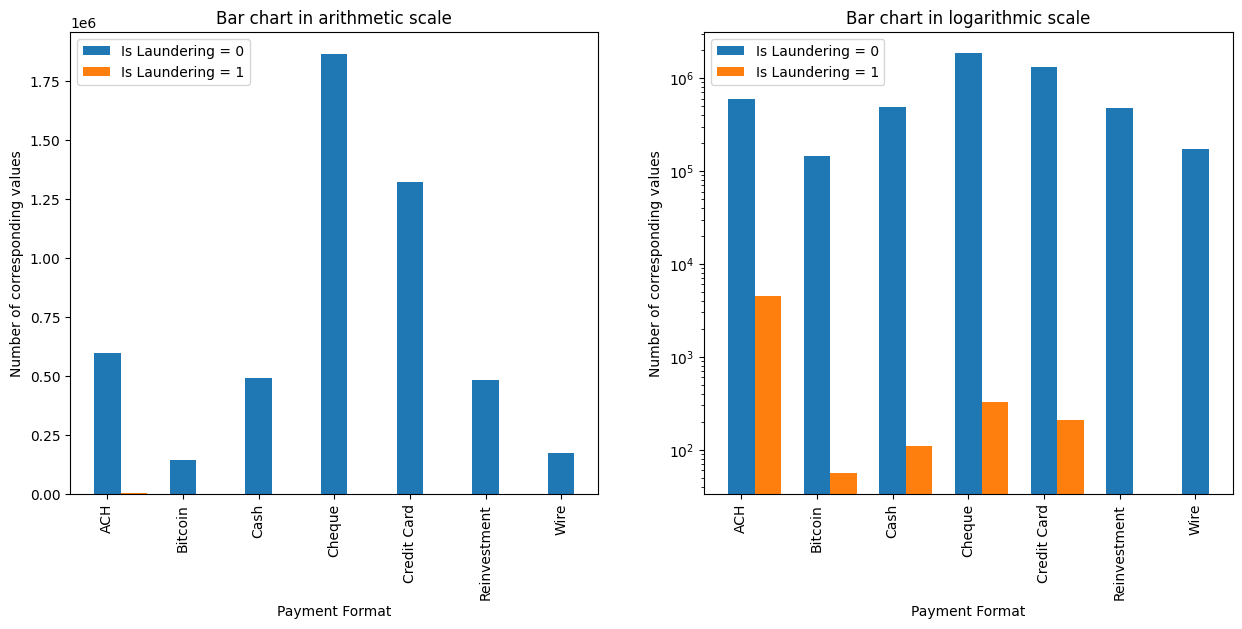

In [8]:
import matplotlib.pyplot as plt

spark_df.select('payment_format', 'is_laundering') \
    .groupBy('payment_format') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ).orderBy('1', ascending=False).show(truncate=False)

# Calculate the number of corresponding values for each value of the "Payment Format" and "Is Laundering" columns
grouped_df = spark_df.groupBy("payment_format", "is_laundering").count()

# Convert Spark DataFrame to Pandas DataFrame
count_values = grouped_df.toPandas()

# Use the unstack() method
count_values_payment = count_values.pivot(index='payment_format', columns='is_laundering', values='count')

# Create a bar chart with a logarithmic scale
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values_payment.index))
axs[0].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[0].set_xlabel('Payment Format')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

axs[1].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[1].set_xlabel('Payment Format')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()


# Display payment currency in relation to laundering transaction

+-----------------+----+-------+
|payment_currency |1   |0      |
+-----------------+----+-------+
|US Dollar        |1912|1893260|
|Euro             |1372|1166925|
|Saudi Riyal      |374 |88640  |
|Swiss Franc      |193 |234667 |
|Yuan             |184 |213568 |
|Rupee            |167 |190035 |
|Yen              |155 |155054 |
|Ruble            |133 |155045 |
|UK Pound         |132 |180606 |
|Canadian Dollar  |128 |139914 |
|Australian Dollar|127 |136642 |
|Shekel           |95  |192089 |
|Mexican Peso     |92  |110067 |
|Brazil Real      |57  |70646  |
|Bitcoin          |56  |146010 |
+-----------------+----+-------+



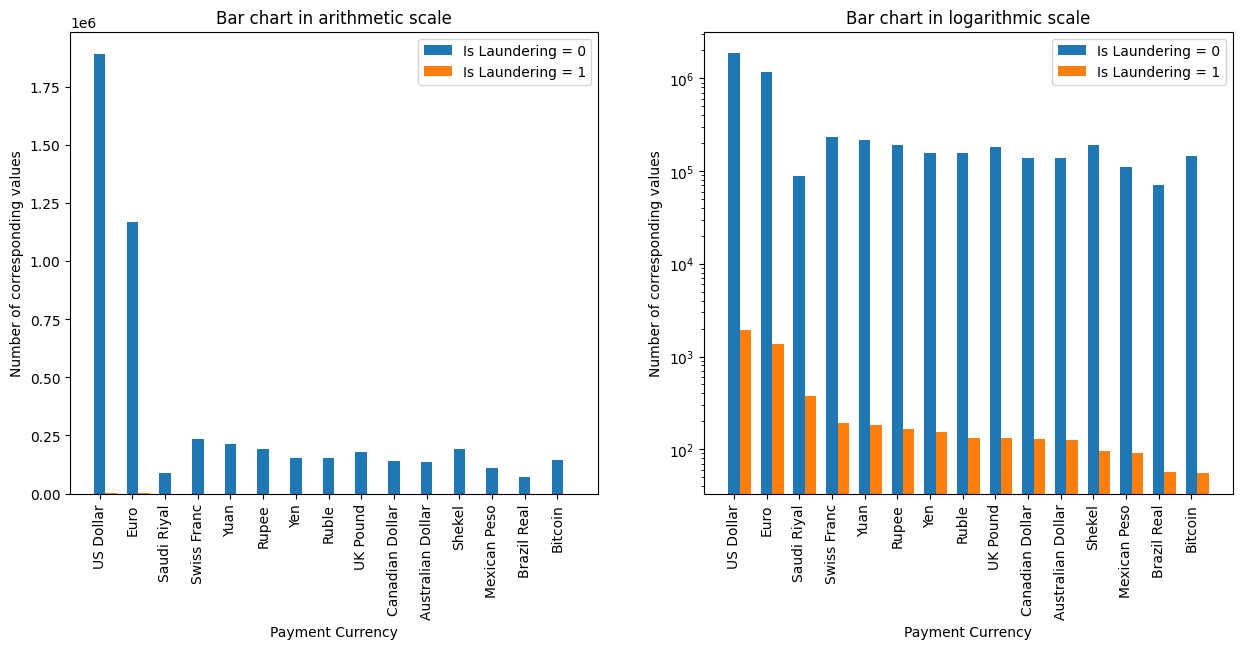

In [9]:
spark_df.select('payment_currency', 'is_laundering') \
    .groupBy('payment_currency') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ).orderBy('1', ascending=False).show(truncate=False)

grouped_df = spark_df.groupBy("payment_currency", "is_laundering").count()

# Convert Spark DataFrame to Pandas DataFrame
count_values = grouped_df.toPandas()

# Use the unstack() method
count_values_currency = count_values.pivot(index='payment_currency', columns='is_laundering', values='count')

# Sort the values by Is Laundering = 1 in descending order
count_values_currency = count_values_currency.sort_values(1, ascending=False)

# Create a bar chart with a logarithmic scale
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values_currency.index))
axs[0].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values_currency.index, rotation='vertical') 
axs[0].set_xticklabels(count_values_currency.index)
axs[0].set_xlabel('Payment Currency')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

axs[1].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values_currency.index, rotation='vertical') 
axs[1].set_xticklabels(count_values_currency.index)
axs[1].set_xlabel('Payment Currency')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()

# Display top 10 accounts for fraudolent transactions

In [10]:
spark_df.select(col('from_account').alias('account'), col('is_laundering'))\
.filter(col('is_laundering') == 1).groupBy('account')\
.agg(count('*').alias('count_laundering'))\
.orderBy('count_laundering', ascending=False)\
.show(10)

+---------+----------------+
|  account|count_laundering|
+---------+----------------+
|100428660|             243|
|1004286A8|             158|
|100428978|              29|
|80266F880|              29|
|100428810|              26|
|812D22980|              25|
|100428738|              23|
|811C597B0|              21|
|811C599A0|              21|
|8021353D0|              21|
+---------+----------------+
only showing top 10 rows



# Display top 20 accounts for transactions

In [34]:
spark_df.select(col('from_account').alias('account'))\
.groupBy('account')\
.agg(count('*').alias('count_transactions'))\
.orderBy('count_transactions', ascending=False)\
.show(20)

+---------+------------------+
|  account|count_transactions|
+---------+------------------+
|100428660|            168672|
|1004286A8|            103018|
|100428978|             20497|
|1004286F0|             18663|
|100428780|             17264|
|1004289C0|             16794|
|100428810|             16426|
|1004287C8|             14174|
|100428738|             13756|
|100428A51|             13073|
|1004288A0|             12330|
|100428858|             11000|
|1004288E8|              9471|
|100428A08|              8290|
|100428930|              6431|
|800058B80|               351|
|80006FCE0|               296|
|800058920|               279|
|80005ADE0|               276|
|800105F00|               274|
+---------+------------------+
only showing top 20 rows



# Display relationhip between amount paid and laundering transaction

+-------------+--------+-------------+-------------------+
|is_laundering|     min|          max|               mean|
+-------------+--------+-------------+-------------------+
|            0|  1.0E-6|1.04630236E12|  4477000.057857941|
|            1|0.003227| 8.4853146E10|3.613531071586281E7|
+-------------+--------+-------------+-------------------+



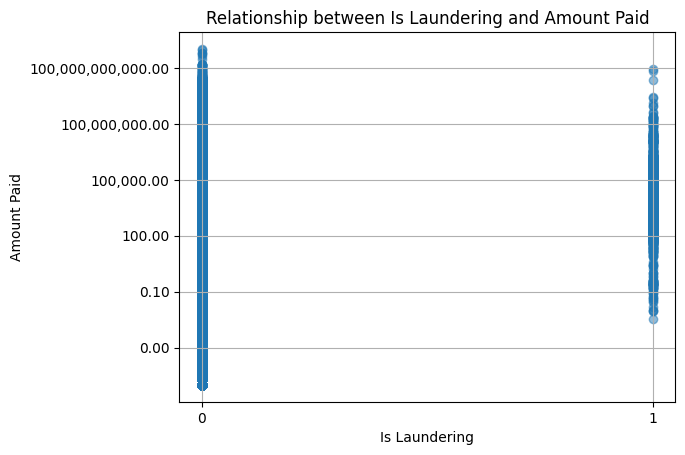

In [11]:
grouped_stats = spark_df.groupBy('is_laundering').agg(
    min(col('amount_paid')).alias('min'),
    max(col('amount_paid')).alias('max'),
    mean(col('amount_paid')).alias('mean')
)

# Mostra le statistiche
grouped_stats.show()


# Estrai il DataFrame Spark come Pandas DataFrame
df_pd = spark_df.toPandas()

# Applica la scala logaritmica e la formattazione numerica
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(x, ',.2f')))

# Crea il grafico scatter
plt.scatter(df_pd['is_laundering'], df_pd['amount_paid'], alpha=0.5)
plt.title("Relationship between Is Laundering and Amount Paid")
plt.xlabel("Is Laundering")
plt.ylabel("Amount Paid")
plt.xticks([0, 1])
plt.grid(True)
plt.show()

# Analyze timestamp

In [41]:
spark_df = spark_df.withColumn("timestamp", to_timestamp("timestamp", "yyyy/MM/dd HH:mm"))

# Split the timestamp column into separate components
spark_df = spark_df.withColumn("year", year("timestamp"))\
                             .withColumn("month", month("timestamp"))\
                             .withColumn("day", dayofmonth("timestamp"))\
                             .withColumn("hour", hour("timestamp"))\
                             .withColumn("minute", minute("timestamp"))

spark_df.show(5)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+----+-----+---+----+------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|year|month|day|hour|minute|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+----+-----+---+----+------+
|2022-09-01 00:20:00|       10|   8000EBD30|     10| 8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|2022|    9|  1|   0|    20|
|2022-09-01 00:20:00|     3208|   8000F4580|      1| 8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|2022|    9|  1|   0|    20|
|2022-09-01 00:00:00|     3209|   8000F4670|   3209| 8000F4670|       14675.57| 

In [44]:
def laundering_for(col_name: str):
    print(f"Laundering for {col_name}")
    spark_df.select(col_name, 'is_laundering') \
    .groupBy(col_name) \
    .agg(
        sum(col('is_laundering').cast('int')).alias('count(1)'),
        sum((1 - col('is_laundering')).cast('int')).alias('count(0)'),
    ).withColumn("ratio", (col('count(1)')/col('count(0)')).cast('Decimal(20,10)')) \
  .orderBy(col('ratio').desc()) \
  .show(truncate=False)

In [45]:
laundering_for('year')
laundering_for('month')
laundering_for('day')
laundering_for('hour')
laundering_for('minute')

Laundering for year


+----+--------+--------+------------+
|year|count(1)|count(0)|ratio       |
+----+--------+--------+------------+
|2022|5177    |5073168 |0.0010204669|
+----+--------+--------+------------+

Laundering for month


+-----+--------+--------+------------+
|month|count(1)|count(0)|ratio       |
+-----+--------+--------+------------+
|9    |5177    |5073168 |0.0010204669|
+-----+--------+--------+------------+

Laundering for day


+---+--------+--------+------------+
|day|count(1)|count(0)|ratio       |
+---+--------+--------+------------+
|18 |8       |3       |2.6666666667|
|17 |15      |8       |1.8750000000|
|15 |28      |18      |1.5555555556|
|12 |170     |111     |1.5315315315|
|11 |232     |164     |1.4146341463|
|14 |70      |51      |1.3725490196|
|13 |106     |78      |1.3589743590|
|16 |26      |20      |1.3000000000|
|10 |442     |207883  |0.0021261960|
|4  |407     |207023  |0.0019659651|
|3  |391     |206991  |0.0018889710|
|8  |539     |482234  |0.0011177146|
|6  |531     |481558  |0.0011026709|
|7  |497     |482254  |0.0010305772|
|5  |471     |482179  |0.0009768157|
|9  |514     |653953  |0.0007859892|
|2  |408     |754041  |0.0005410846|
|1  |322     |1114599 |0.0002888931|
+---+--------+--------+------------+

Laundering for hour


+----+--------+--------+------------+
|hour|count(1)|count(0)|ratio       |
+----+--------+--------+------------+
|12  |336     |192636  |0.0017442223|
|16  |311     |193096  |0.0016105978|
|11  |295     |193205  |0.0015268756|
|13  |292     |192229  |0.0015190216|
|14  |279     |192508  |0.0014492904|
|15  |263     |194608  |0.0013514347|
|8   |258     |192663  |0.0013391258|
|17  |257     |192897  |0.0013323172|
|18  |255     |193066  |0.0013207919|
|10  |234     |192995  |0.0012124666|
|19  |231     |192593  |0.0011994205|
|9   |217     |192735  |0.0011258983|
|6   |207     |194249  |0.0010656426|
|7   |195     |193141  |0.0010096251|
|5   |188     |193712  |0.0009705129|
|2   |165     |192978  |0.0008550197|
|21  |154     |192038  |0.0008019246|
|4   |154     |193012  |0.0007978779|
|1   |152     |193576  |0.0007852213|
|23  |150     |193195  |0.0007764176|
+----+--------+--------+------------+
only showing top 20 rows

Laundering for minute


+------+--------+--------+------------+
|minute|count(1)|count(0)|ratio       |
+------+--------+--------+------------+
|44    |104     |76765   |0.0013547841|
|49    |98      |77188   |0.0012696274|
|33    |95      |76608   |0.0012400794|
|57    |93      |77737   |0.0011963415|
|48    |91      |77232   |0.0011782681|
|53    |91      |77268   |0.0011777191|
|32    |90      |76985   |0.0011690589|
|56    |90      |77096   |0.0011673757|
|31    |89      |76972   |0.0011562646|
|36    |89      |76983   |0.0011560994|
|55    |89      |77091   |0.0011544798|
|14    |106     |92078   |0.0011511979|
|43    |88      |76807   |0.0011457289|
|50    |88      |76891   |0.0011444772|
|39    |88      |77141   |0.0011407682|
|51    |86      |77080   |0.0011157239|
|11    |100     |90994   |0.0010989736|
|42    |84      |77000   |0.0010909091|
|16    |100     |91917   |0.0010879380|
|59    |84      |77380   |0.0010855518|
+------+--------+--------+------------+
only showing top 20 rows



# Label Encoding values

In [46]:
spark_df = spark_df.drop('timestamp')

In [50]:
columns_to_encode = ['from_account', 'to_account', 'receiving_currency', 'payment_currency', 'payment_format']

# Applica l'indicizzazione delle stringhe a ciascuna colonna
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(spark_df) for col in columns_to_encode]
indexed_df = spark_df
for indexer in indexers:
    indexed_df = indexer.transform(indexed_df)
    

In [52]:
for col in columns_to_encode:
    indexed_df = indexed_df.drop(col).withColumnRenamed(col + "_index", col)

In [57]:
df = indexed_df
df.show(5)

+---------+-------+---------------+-----------+-------------+----+-----+---+----+------+------------+----------+------------------+----------------+--------------+
|from_bank|to_bank|amount_received|amount_paid|is_laundering|year|month|day|hour|minute|from_account|to_account|receiving_currency|payment_currency|payment_format|
+---------+-------+---------------+-----------+-------------+----+-----+---+----+------+------------+----------+------------------+----------------+--------------+
|       10|     10|        3697.34|    3697.34|            0|2022|    9|  1|   0|    20|    186005.0|  160130.0|               0.0|             0.0|           4.0|
|     3208|      1|           0.01|       0.01|            0|2022|    9|  1|   0|    20|    142311.0|  152885.0|               0.0|             0.0|           0.0|
|     3209|   3209|       14675.57|   14675.57|            0|2022|    9|  1|   0|     0|    344256.0|  307076.0|               0.0|             0.0|           4.0|
|       12|     

# Display correlation matrix for fraudolent transactions

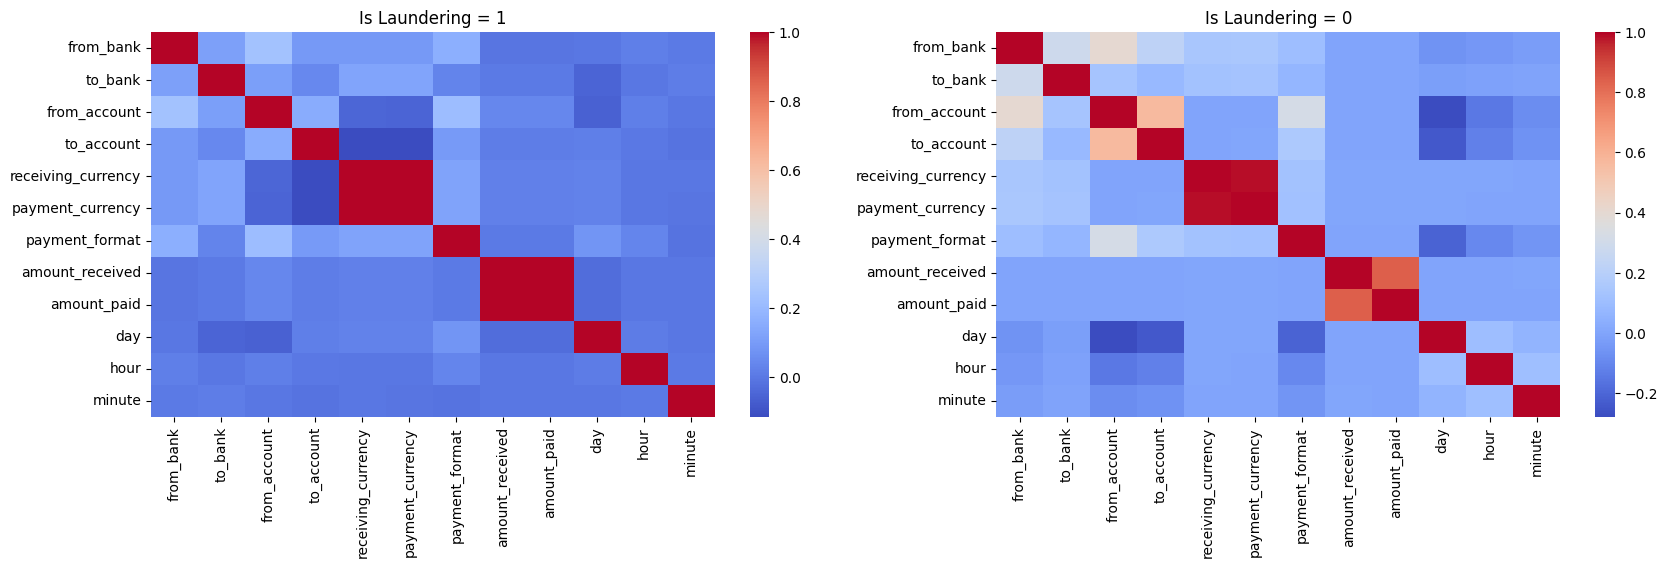

In [64]:
# Seleziona le colonne numeriche su cui calcolare la correlazione
numeric_columns = ['from_bank', 'to_bank', 'from_account', 'to_account','receiving_currency','payment_currency','payment_format', 'amount_received', 'amount_paid',  'day', 'hour', 'minute']

# Crea un VectorAssembler per creare una singola colonna "features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
assembled_df = assembler.transform(df).select("features")

# Filtra il DataFrame Spark in base alla colonna 'is_laundering'
laundering_df = df.filter(df['is_laundering'] == 1)
not_laundering_df = df.filter(df['is_laundering'] == 0)

# Calcola la matrice di correlazione per entrambi i casi
laundering_corr_matrix = laundering_df.select(numeric_columns).toPandas().corr()
not_laundering_corr_matrix = not_laundering_df.select(numeric_columns).toPandas().corr()

# create subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

# plot the first correlation matrix heatmap
sns.heatmap(laundering_corr_matrix, cmap='coolwarm', annot=False, ax=axs[0])
axs[0].set_title('Is Laundering = 1')

# plot the second correlation matrix heatmap
sns.heatmap(not_laundering_corr_matrix, cmap='coolwarm', annot=False, ax=axs[1])
axs[1].set_title('Is Laundering = 0')

# display the plot
plt.show()


In [12]:
print("Laundering:")
count_amount, count_currency = len(df[(df['Amount Received'] == df['Amount Paid']) & (df['Is Laundering'] == 1)]), len(df[(df['Receiving Currency'] == df['Payment Currency']) & (df['Is Laundering'] == 1)])
print(f"    Same amount: {count_amount}")
print(f"    Same currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}\n")

count_amount, count_currency = len(df[(df['Amount Received'] != df['Amount Paid']) & (df['Is Laundering'] == 1)]), len(df[(df['Receiving Currency'] != df['Payment Currency']) & (df['Is Laundering'] == 1)])
print(f"    Different amount: {count_amount}")
print(f"    Different currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}\n")

print("Not Laundering:")
count_amount, count_currency = len(df[(df['Amount Received'] == df['Amount Paid']) & (df['Is Laundering'] == 0)]), len(df[(df['Receiving Currency'] == df['Payment Currency']) & (df['Is Laundering'] == 0)])
print(f"    Same amount: {count_amount}")
print(f"    Same currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}\n")

count_amount, count_currency = len(df[(df['Amount Received'] != df['Amount Paid']) & (df['Is Laundering'] == 0)]), len(df[(df['Receiving Currency'] != df['Payment Currency']) & (df['Is Laundering'] == 0)])
print(f"    Different amount: {count_amount}")
print(f"    Different currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}")

Laundering:
    Same amount: 5177
    Same currency: 5177
    Difference: 0

    Different amount: 0
    Different currency: 0
    Difference: 0

Not Laundering:
    Same amount: 5001010
    Same currency: 5000998
    Difference: 12

    Different amount: 72158
    Different currency: 72170
    Difference: 12


# More correlation among Accounts

Find how many times an Account send laund money and not laund money to the same Account.1

In [13]:
df_temp = df[['Account', 'Account.1', 'Is Laundering']]
df_grouped = df_temp.groupby(['Account', 'Account.1'])['Is Laundering'].nunique().reset_index()
df_grouped[df_grouped['Is Laundering'] > 1].groupby('Account').count().reset_index().rename(columns={'Is Laundering': 'times'}).drop('Account.1', axis=1).sort_values(by='times', ascending=False).head(10)


,Account,times
0,0,236
1,1,156
11,11,28
6,6,26
3,3,22
2,2,21
4,4,21
14,14,18
5,5,16
8,8,16


Find all transactions that are send from A to B with a certain value and from B to C with the same value.

For this it is necessary to use something like graphframes

In [3]:
import sys
sys.path.append("/Users/fabio/jars")

In [16]:
schema = StructType([
    StructField('timestamp', FloatType(), True),
    StructField('from_bank', IntegerType(), True),
    StructField('from_account', IntegerType(), True),
    StructField('to_bank', IntegerType(), True),
    StructField('to_account', IntegerType(), True),
    StructField('amount_received', FloatType(), True),
    StructField('receiving_currency', IntegerType(), True),
    StructField('amount_paid', FloatType(), True),
    StructField('payment_currency', IntegerType(), True),
    StructField('payment_format', IntegerType(), True),
    StructField('is_laundering', IntegerType(), True)])


In [62]:
df = df.rename(columns={'Timestamp': 'timestamp', 'From Bank': 'from_bank', 'Account': 'account1',
                           'To Bank': 'to_bank', 'Account.1': 'account2', 'Amount Received': 'amount_received',
                             'Receiving Currency': 'receiving_currency', 'Amount Paid': 'amount_paid', 'Payment Currency': 'payment_currency',
                               'Payment Format': 'payment_format', 'Is Laundering': 'is_laundering'})
df.to_parquet('df.parquet')

In [5]:
spark_df = spark.read.parquet('df.parquet').drop("__index_level_0__").withColumn("index", monotonically_increasing_id())
spark_df.show(5)

+------------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+
|   timestamp|from_bank|account1|to_bank|account2|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|
+------------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+
|202209010020|       10|     942|     10|     942|        3697.34|                12|    3697.34|              12|             5|            0|42949672960|
|202209010020|     3208|     991|      1|    1002|           0.01|                12|       0.01|              12|             3|            0|42949672961|
|202209010000|     3209|     992|   3209|     992|       14675.57|                12|   14675.57|              12|             5|            0|42949672962|
|202209010002|       12|     998|     12|     998|        2806.9

In [18]:
verteces = spark_df.select(col("account1").alias("id")).union(spark_df.select(col("account2").alias("id"))).distinct()
edges = spark_df.select(col("account1").alias("src"), col("account2").alias("dst"), col("index"), col("amount_paid").alias("amount"), col("timestamp"), col("payment_format"), col("is_laundering"))
g = GraphFrame(verteces, edges)

In [19]:
pattern = g.find("(a)-[c1]->(b); (b)-[c2]->(c) ").filter("""
                                              a != b and
                                              b != c and

                                              c1.amount == c2.amount and
                                              c1.timestamp < c2.timestamp
                                            """)
pattern.show(5, truncate=False)


+--------+---------------------------------------------------+---+---------------------------------------------------+--------+
|a       |c1                                                 |b  |c2                                                 |c       |
+--------+---------------------------------------------------+---+---------------------------------------------------+--------+
|{330838}|{330838, 0, 42953919539, 26.46, 202209090046, 2, 0}|{0}|{0, 478351, 42954632597, 26.46, 202209100905, 3, 0}|{478351}|
|{330838}|{330838, 0, 42953919539, 26.46, 202209090046, 2, 0}|{0}|{0, 478351, 42954054031, 26.46, 202209090533, 3, 0}|{478351}|
|{330838}|{330838, 0, 42951485575, 26.46, 202209022203, 2, 0}|{0}|{0, 478351, 42954632597, 26.46, 202209100905, 3, 0}|{478351}|
|{330838}|{330838, 0, 42951485575, 26.46, 202209022203, 2, 0}|{0}|{0, 478351, 42954054031, 26.46, 202209090533, 3, 0}|{478351}|
|{330838}|{330838, 0, 42951485575, 26.46, 202209022203, 2, 0}|{0}|{0, 478351, 42953725908, 26.46, 202209

In [20]:
array_features =  np.array(pattern.select('c1','c2').collect(), dtype=int).squeeze()

In [21]:
from collections import defaultdict, Counter
dictionary = defaultdict(list)
for array in array_features:
    dictionary[(array[0][5], array[1][5])].append((array[0][6], array[1][6]))

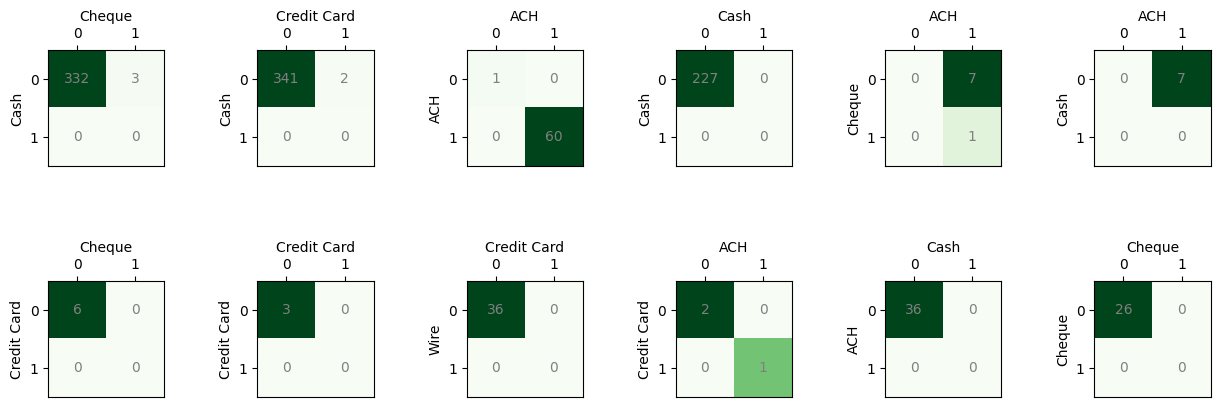

In [22]:
le = LabelEncoder()
le.fit(list(count_values_payment.reset_index()['Payment Format']))
c = Counter()
l = []
matrix = [[0 for _ in range(6)] for _ in range(7)]
data = {}
for key, items in dictionary.items():
    i = Counter(items)
    string = f"{le.inverse_transform([key[0]])[0]}-{le.inverse_transform([key[1]])[0]}"
    data[string] = np.array([[i[(0,0)], i[(0,1)]], [i[(1,0)], i[(1,1)]]])

fig, axs = plt.subplots(2, 6, figsize=(15, 5))

# Loop over each payment type and display the matrix values in the corresponding subplot
for i, (payment, matrix) in enumerate(data.items()):
    # Compute the row and column indices for the current subplot
    row = i // 6
    column = i % 6
    
    # Display the matrix values in the current subplot
    axs[row, column].imshow(matrix, cmap='Greens')
    axs[row, column].set_xticks([0, 1])
    axs[row, column].set_yticks([0, 1])
    axs[row, column].set_xticklabels(['0', '1'])
    axs[row, column].set_yticklabels(['0', '1'])
    axs[row, column].set_xlabel(str(payment.split("-")[1]))
    axs[row, column].set_ylabel(str(payment.split("-")[0]))
    axs[row, column].xaxis.set_label_position('top')
    axs[row, column].yaxis.set_label_position('left')
    axs[row, column].xaxis.set_ticks_position('top')
    axs[row, column].yaxis.set_ticks_position('left')

    for i in range(2):
        for j in range(2):
            axs[row, column].annotate(str(matrix[i, j]), xy=(j, i), ha='center', va='center', color='grey')


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.8, hspace=0.5)

# Show the plot
plt.show()

# Find circular patterns

In [6]:
def find_cycles(g: GraphFrame, hop: int = 2):
    motif = ""

    for i in range(hop):
        motif += "(n" + str(i) + ")-[c" + str(i+1) + "]->(n" + str((i+1) % hop) + "); "
    motif = motif.strip("; ")

    filter_string = ""
    for i in range(hop):
        for j in range(i, hop-1):
            filter_string += "n{} != n{}".format(i, j+1)
            if i+1 < hop-1:
                filter_string += " and "
    filter_string += " and "
    for j in range(1,hop):
            filter_string += "c{}.timestamp < c{}.timestamp".format(j, j+1)
            if(j+1 < hop):
                filter_string += " and "    
    graph = g.find(motif)
    graph = graph.filter(filter_string)
    select_col = []
    for i in range(hop):
        select_col.append("c{}".format(i+1))
    pattern = np.array(graph.select(*select_col).collect()).squeeze()
    total_rows = []

    for row in pattern:
        if isinstance(row[1], np.ndarray):
            for r in row:
                #index | timestamp | from | to | payment_format | is_laundering | hop
                total_rows.append([int(r[2]), r[4], int(r[0]), int(r[1]), int(r[5]), int(r[6]), hop])
        else:
            total_rows.append([int(row[2]), row[4], int(row[0]), int(row[1]), int(row[5]), int(row[6]), hop])

    dataframe = pd.DataFrame(total_rows, columns=['index', 'timestamp', 'from', 'to', 'payment_format', 'is_laundering', 'hop'])

    return dataframe.drop_duplicates()

In [ ]:
spark.stop()

In [7]:
all_df = []
filtered_spark = spark_df.filter(col("payment_currency") == col("receiving_currency"))
filtered_spark.cache()
payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

for j in range(1):
    verteces = filtered_spark.filter(col("payment_format") == j).select(col("account1").alias("id")).union(spark_df.select(col("account2").alias("id"))).distinct()
    edges = filtered_spark.filter(col("payment_format") == j).select(col("account1").alias("src"), col("account2").alias("dst"), col("index"), col("amount_paid").alias("amount"), col("timestamp"), col("payment_format"), col("is_laundering"))
    g = GraphFrame(verteces, edges)
    g = g.dropIsolatedVertices()
    for i in tqdm.tqdm(range(2,14)):
        all_df.append(find_cycles(g, i))

100%|██████████| 12/12 [02:37<00:00, 13.09s/it]                                 


In [34]:
merged_df = pd.concat(all_df, ignore_index=True)

# Step 4: Applica il one-hot encoding sulla colonna "hop"
one_hot_encoded_df = pd.get_dummies(merged_df, columns=['hop'], prefix='hop')
grouped_df = one_hot_encoded_df.groupby('index').agg({
    'timestamp': 'first',
    'from': 'first',
    'to': 'first',
    'payment_format': 'first',
    'is_laundering': 'first',
    'hop_2': 'any',
    'hop_3': 'any',
    'hop_4': 'any',
    'hop_5': 'any',
    'hop_6': 'any',
    'hop_7': 'any',
    'hop_8': 'any',
    'hop_9': 'any',
    'hop_10': 'any',
    'hop_11': 'any',
    'hop_12': 'any',
}).reset_index()
columns_to_encode = ['hop_2', 'hop_3', 'hop_4', 'hop_5', 'hop_6', 'hop_7', 'hop_8', 'hop_9', 'hop_10', 'hop_11', 'hop_12']
grouped_df[columns_to_encode] = grouped_df[columns_to_encode].astype(int)

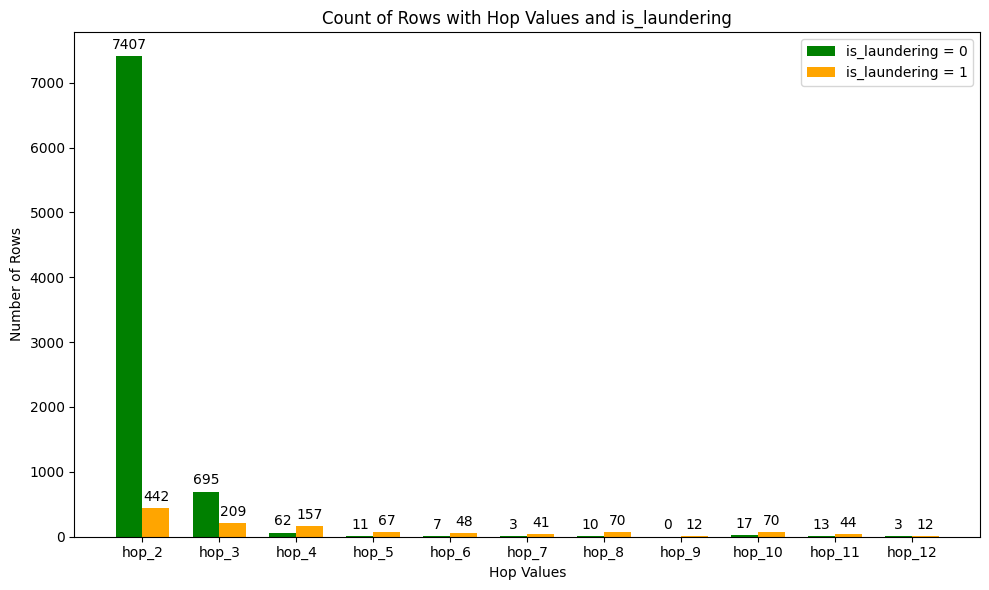

In [35]:
# Calcola il conteggio delle righe che soddisfano le condizioni specificate per ogni valore hop da hop_2 a hop_12
hop_columns = grouped_df.columns[grouped_df.columns.str.startswith('hop_')].tolist()
counts = {}
for hop_column in hop_columns:
    count_0 = grouped_df[(grouped_df[hop_column] == 1) & (grouped_df['is_laundering'] == 0)].shape[0]
    count_1 = grouped_df[(grouped_df[hop_column] == 1) & (grouped_df['is_laundering'] == 1)].shape[0]
    counts[hop_column] = {'0': count_0, '1': count_1}

# Converti i risultati in un DataFrame
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
counts_df = counts_df.rename(columns={'index': 'hop'})

color_0 = 'green'
color_1 = 'orange'

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = counts_df.index
labels = counts_df['hop']
bar_0 = ax.bar(x - width / 2, counts_df['0'], width,  label='is_laundering = 0', color=color_0)
bar_1 = ax.bar(x + width / 2, counts_df['1'], width,  label='is_laundering = 1', color=color_1)

ax.set_xlabel('Hop Values')
ax.set_ylabel('Number of Rows')
ax.set_title('Count of Rows with Hop Values and is_laundering')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add count labels above each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(bar_0)
autolabel(bar_1)

plt.tight_layout()
plt.show()

# Find Fan In 

In [5]:
def find_fanin(g: GraphFrame):
    motif = "(a)-[c1]->(b); (c)-[c2]->(b)"
    filter_motif = "(abs(c1.timestamp - c2.timestamp)) <= 40000 and c1.index != c2.index and c1.payment_currency == c2.payment_currency"#and c1.payment_format == c2.payment_format"
  
    pattern = g.find(motif).filter(filter_motif).select("c1", "c2").distinct()
    fan_in_trans = pattern.groupBy(col("c1")).agg(count("*").alias("fan_in_degree")).select(col("c1").alias("transaction"), col("fan_in_degree"))
    fan_in_trans.cache()
    
    
        
    return fan_in_trans

In [6]:
filtered_spark = spark_df.filter(col("payment_currency") == col("receiving_currency"))
filtered_spark.cache()
payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

total_fan_in = None

for payment_format in payment_formats:
    print(f"Find fan in payment_format: {payment_format}")
    filtered_by_format = filtered_spark.filter(col("payment_format") == payment_format)
    verteces = (
        filtered_by_format.select(col("account1").alias("id"))
        .union(spark_df.select(col("account2").alias("id")))
        .distinct()
    )
    edges = (
        filtered_by_format.select(
            col("account1").alias("src"),
            col("account2").alias("dst"),
            col("index"),
            col("timestamp"),
            col("payment_currency"),
            col("payment_format"),
            col("is_laundering")
            
        )
    )
    g = GraphFrame(verteces, edges)
    if total_fan_in is None:
        total_fan_in = find_fanin(g)
    else:
        total_fan_in = total_fan_in.unionAll(find_fanin(g))

Find fan in payment_format: 0
Find fan in payment_format: 6
Find fan in payment_format: 5
Find fan in payment_format: 1
Find fan in payment_format: 3
Find fan in payment_format: 2
Find fan in payment_format: 4


In [12]:
# Definisci la funzione UDF per estrarre i valori dalla colonna "transaction" e creare una struttura
def extract_values(transaction):
    src, dst, index, timestamp, payment_currency, payment_format, is_laundering = transaction
    return (src, dst, index, timestamp,payment_currency,  payment_format, is_laundering)

# Definisci lo schema per il DataFrame Spark
schema = StructType([
    StructField("src", IntegerType(), True),
    StructField("dst", IntegerType(), True),
    StructField("index", IntegerType(), True),
    StructField("timestamp", FloatType(), True),
    StructField("payment_currency", IntegerType(), True),
    StructField("payment_format", IntegerType(), True),
    StructField("is_laundering", IntegerType(), True)
])

In [13]:
# Applica la funzione UDF per estrarre i valori dalla colonna "transaction" e crea un nuovo DataFrame
extract_udf = udf(extract_values, schema)
new_spark_df = total_fan_in.withColumn("extracted", extract_udf("transaction"))

# Seleziona le colonne necessarie e converte il DataFrame Spark in un DataFrame Pandas
pandas_df = new_spark_df.select("extracted.*", "fan_in_degree").toPandas()


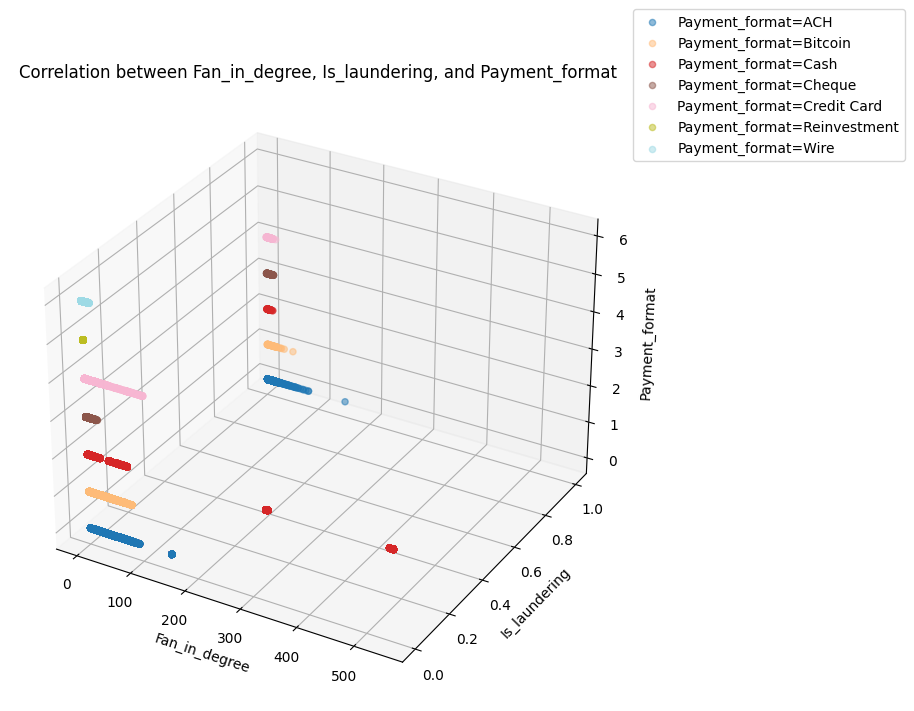

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Assume you have loaded the DataFrame 'df' with the data

# Filter out rows where timestamp is NaN (if needed)
# df = df.dropna(subset=['timestamp'])

# Create a color map for different payment_formats
num_unique_payment_formats = pandas_df['payment_format'].nunique()
color_map = cm.get_cmap('tab20', num_unique_payment_formats) # Choose 'tab20' colormap for more distinct colors

# Mapping dictionary for payment_format names
payment_format_names = {
    0: 'ACH',
    1: 'Bitcoin',
    2: 'Cash',
    3: 'Cheque',
    4: 'Credit Card',
    5: 'Reinvestment',
    6: 'Wire',
    # Add more mappings as needed
}

# Replace the payment_format values with their desired names
pandas_df['payment_format_name'] = pandas_df['payment_format'].map(payment_format_names)

# Create a 3D scatter plot
fig = plt.figure(figsize=(25, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with different colors based on payment_format
for i, (payment_format, group_df) in enumerate(pandas_df.groupby('payment_format_name')):
    color = color_map(i / num_unique_payment_formats)  # Map payment_format to a color from the colormap
    ax.scatter(group_df['fan_in_degree'], group_df['is_laundering'], group_df['payment_format'],
               alpha=0.5, marker='o', color=color, label=f'Payment_format={payment_format}')

# Set axis labels
ax.set_xlabel('Fan_in_degree')
ax.set_ylabel('Is_laundering')
ax.set_zlabel('Payment_format')

# Set the title
ax.set_title('Correlation between Fan_in_degree, Is_laundering, and Payment_format')

# Create a custom legend outside of the 3D plot
ax.legend(loc='center left', bbox_to_anchor=(1, 1))

plt.show()

# Find fan out

In [19]:

def find_fanout(g: GraphFrame):
    motif = "(a)-[c1]->(b); (a)-[c2]->(c)"
    filter_motif = "(abs(c1.timestamp - c2.timestamp)) <= 40000 and c1.index != c2.index"
  
    pattern = g.find(motif).filter(filter_motif).select("c1", "c2").distinct()
    fan_out_trans = pattern.groupBy(col("c1")).agg(count("*").alias("fan_out_degree")).select(col("c1").alias("transaction"), col("fan_out_degree"))
    fan_out_trans.cache()
    
    
        
    return fan_out_trans

In [20]:
filtered_spark = spark_df.filter(col("payment_currency") == col("receiving_currency"))
filtered_spark.cache()
payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

total_fan_out = None

for payment_format in range(2):
    print(f"Find fan in payment_format: {payment_format}")
    filtered_by_format = filtered_spark.filter(col("payment_format") == payment_format)
    verteces = (
        filtered_by_format.select(col("account1").alias("id"))
        .union(spark_df.select(col("account2").alias("id")))
        .distinct()
    )
    edges = (
        filtered_by_format.select(
            col("account1").alias("src"),
            col("account2").alias("dst"),
            col("index"),
            col("timestamp"),
            col("payment_format"),
            col("is_laundering")
        )
    )
    g = GraphFrame(verteces, edges)
    if total_fan_out is None:
        total_fan_out = find_fanout(g)
    else:
        total_fan_out = total_fan_out.unionAll(find_fanout(g))

23/08/01 13:50:18 WARN CacheManager: Asked to cache already cached data.


Find fan in payment_format: 0
Find fan in payment_format: 1


In [21]:
# Definisci la funzione UDF per estrarre i valori dalla colonna "transaction" e creare una struttura
def extract_values(transaction):
    src, dst, index, timestamp, payment_format, is_laundering = transaction
    return (src, dst, index, timestamp, payment_format, is_laundering)

# Definisci lo schema per il DataFrame Spark
schema = StructType([
    StructField("src", IntegerType(), True),
    StructField("dst", IntegerType(), True),
    StructField("index", IntegerType(), True),
    StructField("timestamp", FloatType(), True),
    StructField("payment_format", IntegerType(), True),
    StructField("is_laundering", IntegerType(), True)
])

In [22]:
# Applica la funzione UDF per estrarre i valori dalla colonna "transaction" e crea un nuovo DataFrame
extract_udf = udf(extract_values, schema)
new_spark_df = total_fan_out.withColumn("extracted", extract_udf("transaction"))

# Seleziona le colonne necessarie e converte il DataFrame Spark in un DataFrame Pandas
pandas_df = new_spark_df.select("extracted.*", "fan_out_degree").toPandas()

/tmp/ipykernel_1459705/1644596059.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_unique_payment_formats)


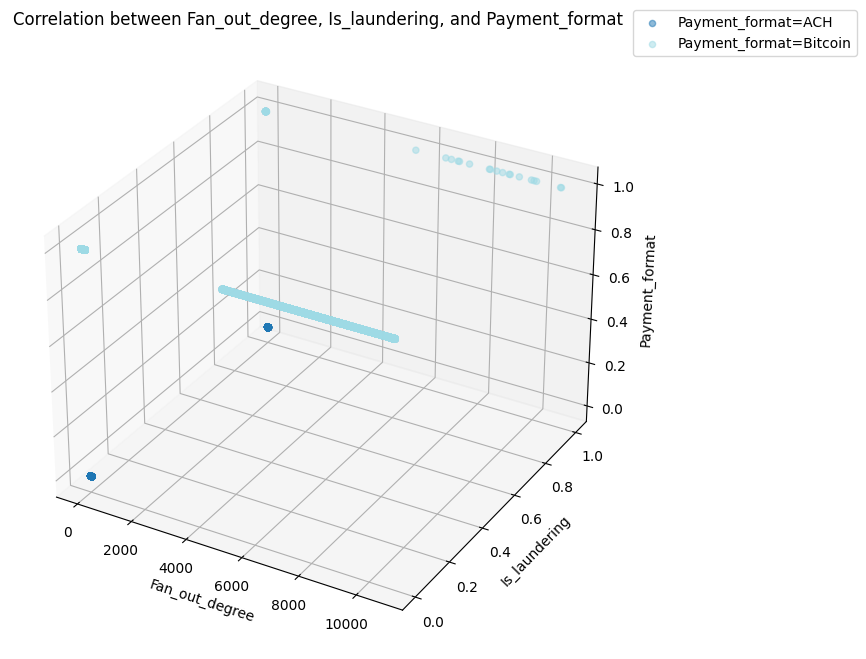

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


num_unique_payment_formats = pandas_df['payment_format'].nunique()
color_map = cm.get_cmap('tab20', num_unique_payment_formats) 

# Mapping dictionary for payment_format names
payment_format_names = {
    0: 'ACH',
    1: 'Bitcoin'
}

# Replace the payment_format values with their desired names
pandas_df['payment_format_name'] = pandas_df['payment_format'].map(payment_format_names)

# Create a 3D scatter plot
fig = plt.figure(figsize=(25, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with different colors based on payment_format
for i, (payment_format, group_df) in enumerate(pandas_df.groupby('payment_format_name')):
    color = color_map(i / num_unique_payment_formats)  # Map payment_format to a color from the colormap
    ax.scatter(group_df['fan_out_degree'], group_df['is_laundering'], group_df['payment_format'],
               alpha=0.5, marker='o', color=color, label=f'Payment_format={payment_format}')

# Set axis labels
ax.set_xlabel('Fan_out_degree')
ax.set_ylabel('Is_laundering')
ax.set_zlabel('Payment_format')

# Set the title
ax.set_title('Correlation between Fan_out_degree, Is_laundering, and Payment_format')

# Create a custom legend outside of the 3D plot
ax.legend(loc='center left', bbox_to_anchor=(1, 1))

plt.show()

# End analysis